# Extracting the polarized phase function, PDS70

This tutorial showcases the functionalities of *diskmap*. We will use a polarized scattered light image of the PDS70 circumstellar disk. The data were obtained with [VLT/SPHERE](https://www.eso.org/sci/facilities/paranal/instruments/sphere.html) in the $J$ band and have been published by [Thalmann et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...828L..17T/abstract).

## Getting started

We start by importing the Python modules that are required for this tutorial.

In [1]:
import diskmap
import glob
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from astropy.io import fits

Let's read the fits file

In [2]:
image = fits.getdata('PDS_70_SPHERE_2016-03-26_J.fits')
image=image[1]

In [3]:
image.shape

(1024, 1024)

Let's have a look at the image. The central masked region contains NaNs.

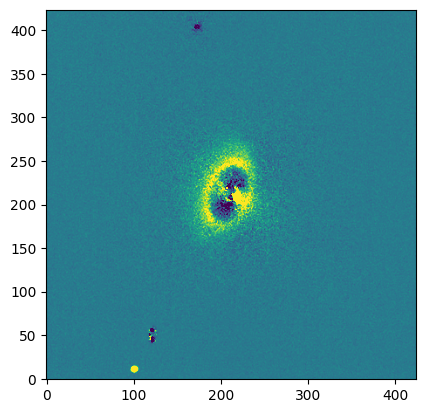

In [4]:
plt.imshow(image[300:724,300:724], origin='lower', vmin=0.1*np.nanmin(image), vmax=0.1*np.nanmax(image))

## Mapping of the disk surface

We will now create an instance of `DiskMap` by providing the FITS filename, the pixel scale of the detector (12.25 mas for SPHERE/IRDIS), the inclination (49.5 deg) and position angle (158.6 deg) of the disk, the distance (112.4 pc), and the image type (polarized flux).

The inclination convention is such that the near side is located on the right side of the image when using an inclination between 0 and 90 deg and a position angle of 0 deg. Therefore, with an position angle of 90 deg, the near side will be in upward direction of the image, as we will also see later in the `_radius.fits` file.

In [5]:
mapping = diskmap.DiskMap(image,
                          pixscale=0.01225,
                          inclination=49.5,
                          pos_angle=158.6+180.,
                          distance=112.4,
                          image_type='polarized')

/home/thomas/.local/lib/python3.10/site-packages/diskmap/diskmap.py:94: UserWarning: The FITS file data is of type float32, this will be converted to float64
  warnings.warn(


The scattering surface of the disk is mapped with the `map_disk` method. The height of the scattering surface is parametrized with a power-law funtion, $h(r) = a + b*(r/1\,\mathrm{au})^c$, with $a$, $b$, $r$, and $h(r)$ in au, and is set with the argument of `power_law` as `(a, b, c)`. In this example, we assume a constant opening angle for the disk surface: $h(r) = 0 + 0.05r^{1}$. The argument of `radius` specifies the sampling of the radii, here 100 points between 1 and 500 au.

For running the deprojection later on, it is important that the outer radius of the `radius` parameter is larger than the field of view of the image. This may not be possible if the disk is strongly inclined and flaring. A mapping of the full field of view is not required for the $r^2$ scaling and phase function extraction. In that case, a smaller outer radius can be used, for example the actual outer radius of the disk. The radius and scattering angle output will contain NaNs beyond the outer radius.

In [6]:
mapping.map_disk(power_law=(0., 0.041, 1.25),
                 radius=(1., 500., 100))

## Radius and scattering angle

The available output from the `DiskMap` methods are written by calling `write_output`. The argument of `filename` contains the prefix of the output files.

In [7]:
mapping.write_output(filename='pds70')

Let's see which FITS files have been written.

In [8]:
glob.glob('*.fits')

['pds70_scat_angle.fits',
 'imlup_r2_scaled.fits',
 'imlup_scat_angle.fits',
 'lkca15_irdis_qphi.fits',
 'IM_Lup_SPHERE_2016-03-14_H.fits',
 'pds70_radius.fits',
 'PDS_70_SPHERE_2016-03-26_J.fits',
 'imlup_radius.fits',
 'pds70_r2_scaled.fits']

For simplicity with the plots, we define half the field of view in arcseconds.

In [9]:
size = mapping.pixscale * image.shape[0]/2

The deprojected radius (in au) from the disk surface to the star is stored in the `_radius.fits` file. Let's plot the image from this FITS file.

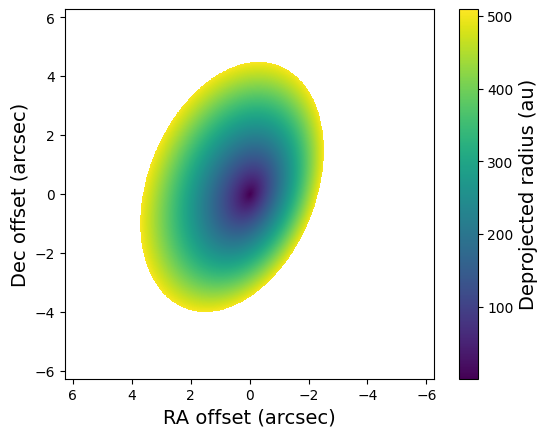

In [10]:
radius = fits.getdata('pds70_radius.fits')
plt.imshow(radius, origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Deprojected radius (au)', size=14)

Similarly, the scattering angles on the disk surface are stored in the `_scat_angle.fits` file. The scattering angle is defined as 180 degrees minus the angle between the direction from the disk surface to the star and the direction from the disk surface to the observer.

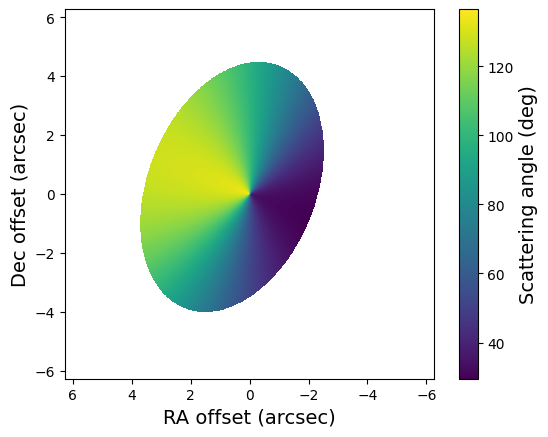

In [11]:
scat_angle = fits.getdata('pds70_scat_angle.fits')
plt.imshow(scat_angle, origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Scattering angle (deg)', size=14)

## Irradiation correction

Now that we have the deprojected distance from each pixel to the star, we can compute the stellar irradiation corrected (i.e. $r^2$ scaled) image. We set a maximum radius of 100 au such that the flux at large separations, which only consists of noise, is not enhanced by the scaling.

In [12]:
mapping.r2_scaling(r_max=100.)

We run again the `write_output` method such that also the r$^2$ scaled image is stored as FITS file.

In [13]:
mapping.write_output(filename='pds70')

Let's have a look at the r$^2$ scaled image. The dynamical range is smaller compared to the regular image which brings out the disk features more clearly.

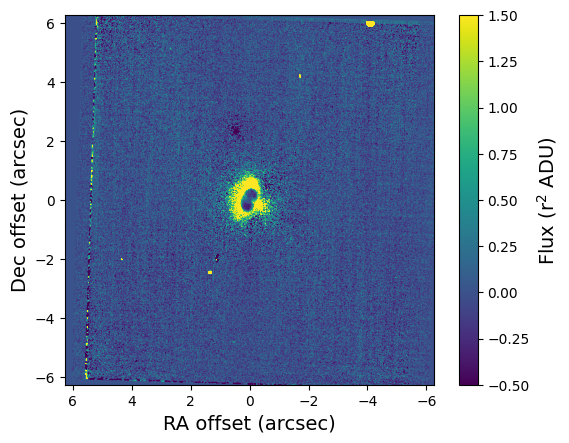

In [14]:
r2_scaled = fits.getdata('pds70_r2_scaled.fits')
plt.imshow(r2_scaled, origin='lower', extent=[size, -size, -size, size],vmin=-0.5,vmax=1.5)
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='Flux (r$^2$ ADU)', size=14)

## Scattering phase function

As a last step, we extract the scattering phase function from, that is, the normalized flux as function of scattering angle. We use the `phase_function` method and select pixels between a deprojected distance of 80 and 100 au (i.e. along the bright ring in the r$^2$-scaled image) and caculate the average flux in 30 steps between 0 and 180 degrees.

In [15]:
mapping.phase_function(radius=(42., 73.), n_phase=30)

We run again the `write_output` method to store the phase function in a text file.

In [16]:
mapping.write_output(filename='pds70')

We can read the extracted phase function with the `loadtxt` function of `numpy`. The second and third column of the data file contain the extracted phase function and error, which in this case is the polarized phase function. The fourth and fifth column contains an extimated total intensity phase function, which assumes that the degree of polarization is bell-shaped.

In case the input image is a total intensity image (i.e. `image_type='total'`), the data file contains only the regular / total intensity phase function.

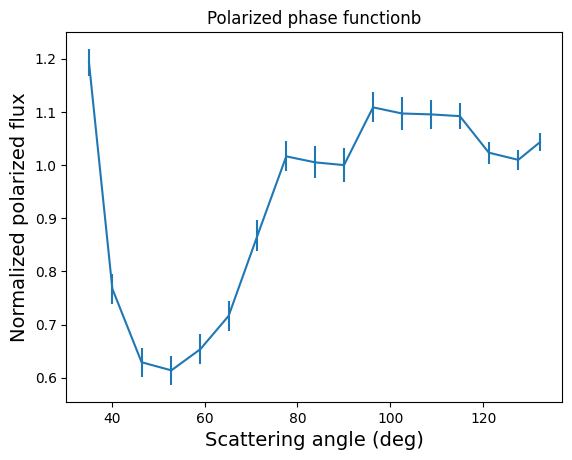

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
angles_obs, pol_flux_obs, pol_error, total_flux, total_error = np.loadtxt('pds70_phase_function.dat', unpack=True)

# We normalize to the polized flux at 90 degree.
pol_flux_obs = pol_flux_obs / pol_flux_obs[np.argmin(np.abs(angles_obs - 90))]
plt.errorbar(angles_obs, pol_flux_obs, yerr=pol_error, label="PI")
plt.xlabel('Scattering angle (deg)', fontsize=14)
plt.ylabel('Normalized polarized flux', fontsize=14)
plt.title('Polarized phase functionb')
plt.show()

Let's plot the polarized phase function that is extracted from the r$^2$-scaled image, normalized to the phase function at 90 degrees.

pyr-mg70 0.87 c 0.13 


.....
.
Writing full scattering data to file: optool_tmp_output_dir_185230/dustkapscatmat.dat


Reading optool_tmp_output_dir_185230/dustkapscatmat_001.dat ...
Cleaning up temporary directory optool_tmp_output_dir_185230


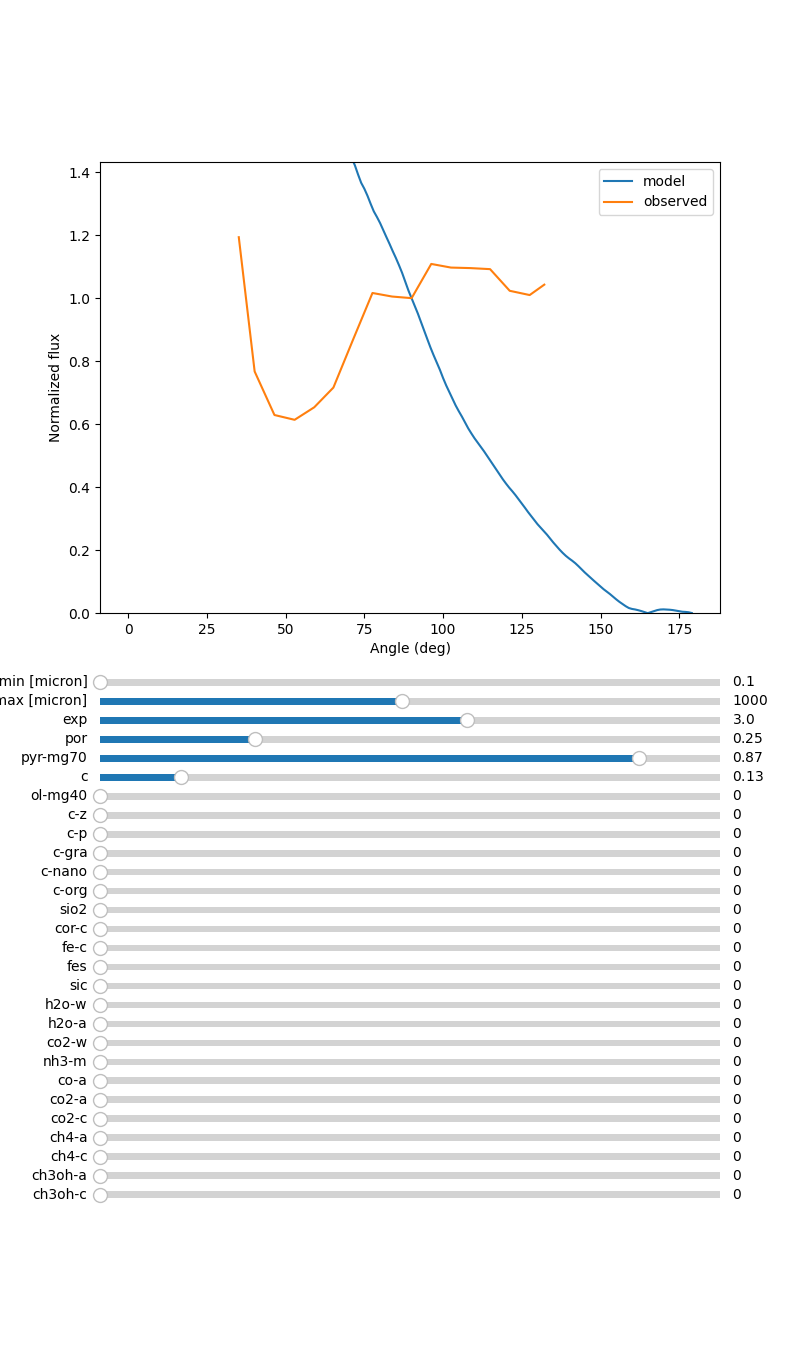

In [7]:
from functools import lru_cache
import optool
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget


@lru_cache(maxsize=10)
def optool_call(s):
    """
    Call optool with caching of results for performance.

    Parameters
    ----------
    s : str
        Command line string for optool.

    Returns
    -------
    optool.particle : object
        Optool particle object constructed from parameters in s.
    """
    p = optool.particle(s)
    return p


def compute_model(amin, amax, exp, por, material, wavelength_micron, sizebins):
    """
    Compute the phase function for a given set of parameters and materials.

    Materials with abundances lower than 1e-2 are ignored.

    Example material dict:
    material = {
        "pyr-mg70": 0.87,
        "c": 0.13,
    }

    Parameters
    ----------
    amin : float
        Minimum grain size.
    amax : float
        Maximum grain size.
    exp : float
        Exponent of the power-law grain size distribution.
    por : float
        Porosity.
    material : dict
        Dictionary with material names and their corresponding abundances.
    wavelength_micron : float
        Wavelength in micrometers.
    sizebins : int
        Number of size bins for the grain size distribution.

    Returns
    -------
    angles_model : ndarray
        Array of angles for which the model is computed.
    pol_flux_model : ndarray
        Computed polarized flux for each angle.
    """
    materials_str = ""
    for m, x in material.items():
        # Ignore materials with abundance < 0.01
        if float(x) > 1e-2:
            materials_str += f"{m} {x} "
    print(materials_str)
    cmd = f"optool {materials_str} -p {por} -a {amin} {amax} {exp} {sizebins} -l {wavelength_micron} -s"
    p = optool_call(cmd)
    f12 = np.abs(p.f12[0][0])
    angles_model = np.arange(0, 180)
    pol_flux_model = f12/f12[len(f12)//2]
    return angles_model, pol_flux_model


def polarized_flux_widget(angles_obs, 
                          pol_flux_obs, 
                          materials, 
                          wavelength_micron,     
                          init_amin=0.1,
                          init_amax=1000,
                          init_exp=3,
                          init_por=0.25):
    """
    Interactively display a plot of observed and modeled polarized flux, allowing user
    to adjust parameters via sliders.

    Parameters
    ----------
    angles_obs : ndarray
        Observed angles.
    pol_flux_obs : ndarray
        Observed polarized flux for each angle.
    materials : dict
        Dictionary with material names and their initial relative abundances.
    wavelength_micron : float
        Wavelength in micrometers for the plot.
    init_amin : float, optional
        Initial minimum grain size (default is 0.1).
    init_amax : float, optional
        Initial maximum grain size (default is 1000).
    init_exp : float, optional
        Initial exponent of the grain size distribution (default is 3).
    init_por : float, optional
        Initial porosity (default is 0.25).
    """

    # Create a figure with axes for each parameter slider and the plot.
    axes_names = [
        "plot", ".", ".", ".", "slamin", "slamax", "slexp", "slpor"
    ] + [f"sl{m}" for m in materials]

    height_ratios = [1] + [0.03] * (len(axes_names) - 1)

    fig, axd = plt.subplot_mosaic([[a] for a in axes_names],
                                  height_ratios=height_ratios,
                                  figsize=(8, 6+0.25*(len(axes_names)-2)))

    angles_model, pol_flux_model = compute_model(
        init_amin, init_amax, init_exp, init_por, materials, wavelength_micron=wavelength_micron, sizebins=30)
    
    line, = axd["plot"].plot(angles_model, pol_flux_model, label="model")
    axd["plot"].plot(angles_obs, pol_flux_obs, label="observed")
    axd["plot"].legend()
    axd["plot"].set_xlabel("Angle (deg)")
    axd["plot"].set_ylabel("Normalized flux")
    axd["plot"].set_ylim(0, 1.2*np.max(pol_flux_obs))

    # Make a horizontal sliders to control model parameters.
    sliders = {}

    amin_slider = Slider(
        ax=axd["slamin"],
        label='amin [micron]',
        valmin=0.1,
        valmax=1,
        valinit=init_amin,
    )
    sliders["amin"] = amin_slider

    amax_slider = Slider(
        ax=axd["slamax"],
        label='amax [micron]',
        valmin=50,
        valmax=2000,
        valinit=init_amax,
    )
    sliders["amax"] = amax_slider

    exp_slider = Slider(
        ax=axd["slexp"],
        label='exp',
        valmin=0.1,
        valmax=5,
        valinit=init_exp,
    )
    sliders["exp"] = exp_slider

    por_slider = Slider(
        ax=axd["slpor"],
        label='por',
        valmin=0,
        valmax=1,
        valinit=init_por,
    )
    sliders["por"] = por_slider

    for m, c in materials.items():
        sl = Slider(
            ax=axd[f"sl{m}"],
            label=m,
            valmin=0,
            valmax=1,
            valinit=c,
        )
        sliders[m] = sl

    # The function to be called anytime a slider's value changes
    def update(val):
        amin = amin_slider.val
        amax = amax_slider.val
        exp = exp_slider.val
        por = por_slider.val
        mats = {m: sliders[f"{m}"].val for m in materials.keys()}
        angles_model, pol_flux_model = compute_model(
            amin, amax, exp, por, mats, wavelength_micron=wavelength_micron, sizebins=30)
        line.set_ydata(pol_flux_model)
        fig.canvas.draw_idle()

    # Update the plot when mouse button is released instead of on update.
    # Otherwise the widget quickly becomes unresponsive due to exessive optool calls.
    fig.canvas.mpl_connect("button_release_event", update)

    plt.show()

# Specify the materials used in the model 
materials = {
    "pyr-mg70": 0.87,
    "c": 0.13,
    "ol-mg40": 0.0,
    "c-z": 0.0,
    "c-p": 0.0,
    "c-gra": 0.0,
    "c-nano": 0.0,
    "c-org": 0.0,
    "sio2": 0.0,
    "cor-c": 0.0,
    "fe-c": 0.0,
    "fes": 0.0,
    "sic": 0.0,
    "h2o-w": 0.0,
    "h2o-a": 0.0,
    "co2-w": 0.0,
    "nh3-m": 0.0,
    "co-a": 0.0,
    "co2-a": 0.0,
    "co2-c": 0.0,
    "ch4-a": 0.0,
    "ch4-c": 0.0,
    "ch3oh-a": 0.0,
    "ch3oh-c": 0.0
}
polarized_flux_widget(angles_obs, pol_flux_obs,
                      materials, wavelength_micron=1.25)
